In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from IPython import display
%matplotlib inline


from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report, roc_auc_score, auc

from sklearn.cross_validation import KFold, train_test_split

## Investigation

In [120]:
data = pd.read_csv("../data/train.csv")
data.y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

Значит имеем задачу классификации, классы не сбалансированы. <br/>
В качестве метрики подойдет roc_auc или f1_score, они чувствительны к ошибкам в обоих классах, будем использовать roc_auc. 
  
Хотим сравнить модели отбора признаков, кандидаты следующие, глобально это либо линейные модели с улучшениями для отбора признаков, либо деревья:
- DFS (сетка из статьи)
- Сетки\линейные модели с elastic net или lasso прибавками к ошибке

- Случайный лес
- AdaBoost (на деревьях)
- Градиентный бустинг (тоже на деревьях)
- LightGBM

Зафиксируем сначала просто трейн\тест разбиение, сохранив баланс классов, потом можно будет погонять кросс-валидацию на 3-5 фолдов.

In [121]:
np.random.seed(239)

In [122]:
X = data[data.columns[:-1]].values
y = data.y.values

In [123]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [129]:
## Check ballance
print("train: ", y_tr.sum()/y_tr.shape[0])
print("test: ", y_te.sum()/y_te.shape[0])
print("all: " , y.sum()/y.shape[0])

train:  0.714975845410628
test:  0.7148014440433214
all:  0.7149321266968326


In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
rf = RandomForestClassifier(100)

In [132]:
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
rf_pred = rf.predict_proba(X_te)

In [136]:
print(roc_auc_score(y_te, rf_pred[:,0] < 0.5))

0.8101905127221583


In [121]:
np.argsort(rf.feature_importances_)[::-1]

array([1460,  458, 1077, ...,  791,  794, 1367])

In [118]:
rf.feature_importances_[0]

0.0007573178837438836

In [120]:
np.where(sorted(rf.feature_importances_)[::-1] == rf.feature_importances_[0])

(array([386]),)

In [124]:
roc_auc_score(y_te, rf_pred)

0.4355032790490114

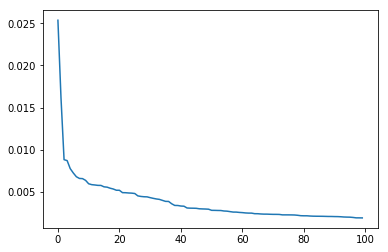

In [138]:
plt.plot(sorted(rf.feature_importances_)[::-1][:100])
plt.show()

In [141]:
rf_feauture_mask = rf.feature_importances_ > 0.002

In [142]:
rf_feauture_mask.sum()

93

In [8]:
from keras.layers import Dense

Using TensorFlow backend.


In [9]:
class WeightLayer:
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out                

In [10]:
class DFS:
    def __init__(self, name, input_shape, dense_sizes = [256, 256]):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.weight_layer = WeightLayer(input_shape, 'wl')

            self.dense_array = [Dense(x, activation=tf.nn.relu) for x in dense_sizes] + [Dense(2, activation=None)]
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                weight_layer_out = self.weight_layer(inp)
                next_var = weight_layer_out
                for layer in self.dense_array:
                    next_var = layer(next_var)
                
                logits = next_var
                out = tf.nn.softmax(logits)
        return logits, out

    def get_weighted_layer_regularization_term(self, alpha):
        with tf.variable_scope("weighted_layer_regularization"):
            return (1-alpha) * tf.reduce_sum(tf.abs(self.weight_layer.w)) +\
                    alpha * tf.reduce_sum(tf.square(self.weight_layer.w))
        
    def get_dense_layers_regularization_term(self, alpha):
        with tf.variable_scope("dense_layers_regularization"):
            r_term = 0
            for layer in self.dense_array:
                r_term += (1-alpha) * tf.reduce_sum(tf.abs(layer.weights[0])) +\
                            alpha * tf.reduce_sum(tf.square(layer.weights[0]))

            return r_term

In [113]:
class NNexperiment:
    def __init__(self,
                 name,
                 feature_mask,
                 session,
                 lambda_1=0.1,
                 lambda_2=0.5,
                 alpha_1=0.0002,
                 alpha_2=0.5,
                 dense_sizes = [256, 256]):
        self.name = name
        self.session = session
        self.feature_mask = feature_mask
        self.n_features = self.feature_mask.sum()
        
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        self.dense_sizes = dense_sizes
        
        self.ready = False
        
    def _initialize_network(self):
        with tf.variable_scope(self.name) as net_scope:
            ## Initialize network
            self.inp = tf.placeholder(tf.float32, [None, self.n_features])
            self.dfs = DFS("DFS", self.n_features, self.dense_sizes)
            self.logits, self.out = self.dfs(self.inp)

            ##Prepare target and loss weights
            self.target = tf.placeholder(tf.float32, [None])
            self.loss_weights = tf.placeholder(tf.float32, [None])

            ##Loss terms
            self.ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(self.target, tf.int32), 2),
                                                           self.logits,
                                                           weights=self.loss_weights)
            self.features_weights_regularization = \
                self.lambda_1 * self.dfs.get_weighted_layer_regularization_term(self.lambda_2)
            self.network_weights_regularization = \
                self.alpha_1 * self.dfs.get_dense_layers_regularization_term(self.alpha_2)

            self.loss = self.ce_loss + self.features_weights_regularization + self.network_weights_regularization

            ## Optimizer, Adam optimizes everything
            self.optimizer = tf.train.AdamOptimizer()
            self.train_step = self.optimizer.minimize(self.loss, var_list=tf.trainable_variables(self.name))

        ## Initialize only this experiment    
        self.uninitialized_vars = []
        for var in tf.all_variables():
            try:
                sess.run(var)
            except tf.errors.FailedPreconditionError:
                self.uninitialized_vars.append(var)

        init_new_vars_op = tf.initialize_variables(self.uninitialized_vars)
        sess.run(init_new_vars_op)
        
        self.net_scope = net_scope
            
    def _plot_graphs(self):
        f, (a1, a2) = plt.subplots(2,1,figsize = (10,10))
        display.clear_output(wait=True)
        a1.plot(self.train_ce_losses[:], label='train ce')
        a1.plot(self.val_ce_losses[:], label = 'val ce')

        a2.plot(self.val_auc_scores[:], label='val_auc')

        a1.legend()
        a2.legend()
        plt.show()
             
        
    def run_experiment(self, X_tr, y_tr, X_te, y_te, max_epochs, b_s=40, plot=True, warm_up=40, early_stop=20):
        if not self.ready:
            self._initialize_network()
            self.ready = True

            self.class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}
            self.val_weights = np.array([self.class_weights[y] for y in y_te])

            self.train_ce_losses = []
            self.val_ce_losses = []
            self.val_auc_scores = []

        for epoch in range(max_epochs):
            train_ce_loss = 0

            for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, b_s)):
                batch_weights = np.array([self.class_weights[y] for y in batch_y])

                batch_loss = self.session.run([self.train_step, self.ce_loss],
                                      feed_dict={self.inp : batch_X[:,self.feature_mask],
                                                 self.target: batch_y,
                                                 self.loss_weights:batch_weights})

                train_ce_loss += batch_loss[1] * batch_X.shape[0]


            val_ce_loss = self.session.run(self.ce_loss,  feed_dict={self.inp : X_te[:,self.feature_mask],
                                                             self.target: y_te,
                                                             self.loss_weights : self.val_weights})
            val_auc_score = roc_auc_score(y_te, self.session.run(self.out,
                                                                 feed_dict={self.inp : X_te[:,self.feature_mask]})[:,1])

            self.val_ce_losses.append(val_ce_loss)
            self.val_auc_scores.append(val_auc_score)
            self.train_ce_losses.append(train_ce_loss / X_tr.shape[0])


            if plot:
                self._plot_graphs()


            if epoch > warm_up:
                if np.argmax(np.array(self.val_auc_scores[-early_stop:])) == 0:
                    print("early stop")
                    break

def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [114]:
tf.reset_default_graph()
sess = tf.Session()

In [115]:
exp_1 = NNexperiment("322", np.ones(X.shape[1]).astype(bool), sess)

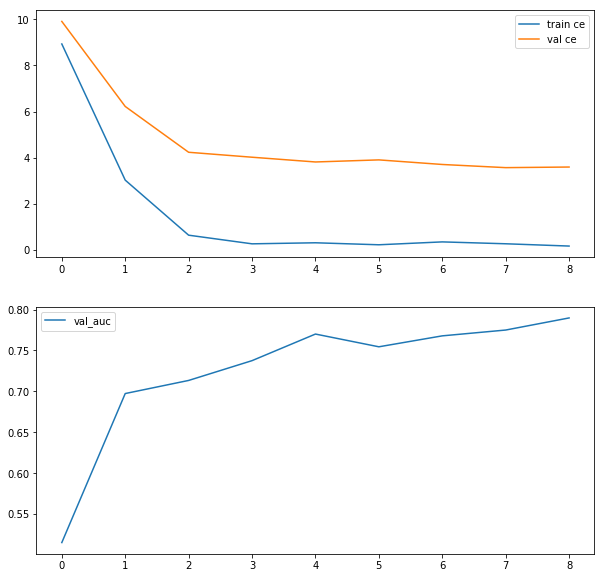

In [118]:
exp_1.run_experiment(X_tr, y_tr, X_te, y_te, 3)

In [92]:
sess.run(exp_1.dfs.weight_layer.w).max()

0.040107314

In [89]:
#sess.run(exp_2.dfs.weight_layer.w).max()

In [90]:
exp_2 = NNexperiment("322_2", np.array([True] * 10 + [False] * 1514), sess)

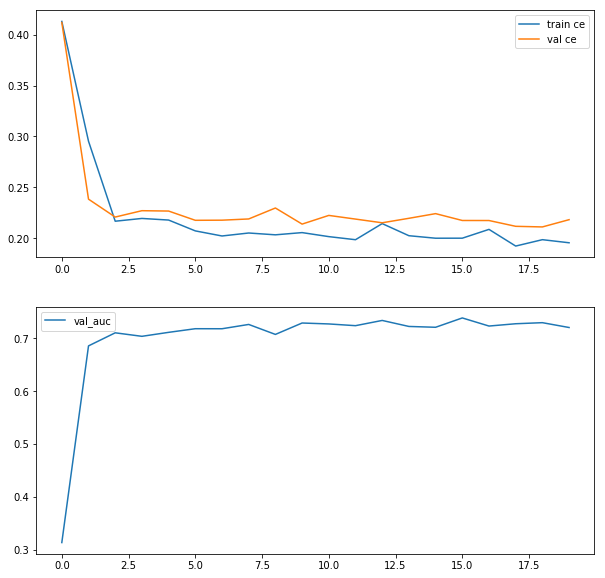

In [91]:
exp_2.run_experiment(X_tr, y_tr, X_te, y_te, 20)

In [36]:
exp_1.dfs.dense_array[0].name

'dense_1'

In [37]:
exp_2.dfs.dense_array[0].name

'dense_4'

In [92]:
writer = tf.summary.FileWriter("../tf_logs", exp_1.graph)

In [97]:
exp_2.session.run(exp_2.dfs.weight_layer.w)

array([-9.3286522e-02, -1.3195953e-04,  1.0772917e-04,  6.6445664e-02,
       -2.2152393e-01, -1.4277481e-01, -1.6413462e-04, -1.0987322e-04,
        3.3156211e-05, -2.1406886e-04], dtype=float32)

In [96]:
exp_1.session.run(exp_1.dfs.weight_layer.w).shape

(1524,)

In [84]:
writer = tf.summary.FileWriter("../tf_logs", exp_1.graph)

In [93]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [105]:
train_ce_loss

[]

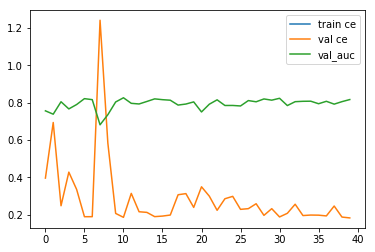

early stop


In [103]:
train_network("test6", sess, np.ones(X.shape[1]).astype(bool))

In [56]:
feature_mask = np.ones(X.shape[1]).astype(bool)
#feature_mask = rf_feauture_mask
n_features = feature_mask.sum()

inp = tf.placeholder(tf.float32, [None, n_features])#X.shape[1]])

dfs = DFS("DFS", n_features)

logits, out = dfs(inp)

In [57]:
target = tf.placeholder(tf.float32, [None])
loss_weights = tf.placeholder(tf.float32, [None])

In [58]:
ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(target, tf.int32), 2), logits, weights=loss_weights)

In [59]:
#regularization_term = 0.001 * tf.reduce_sum(tf.abs(weight_layer.w))

In [60]:
tf.trainable_variables()

[<tf.Variable 'DFS/wl/w:0' shape=(1524,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/kernel:0' shape=(1524, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/kernel:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/bias:0' shape=(2,) dtype=float32_ref>]

In [61]:
# weighted_layer_regularization = tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
# weighted_layer_regularization = 0.05 * weighted_layer_regularization

In [62]:
# regularization = 0#tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
# for layer in dfs.dense_array:
#     regularization += tf.reduce_sum(tf.abs(layer.weights[0])) + tf.reduce_sum(tf.square(layer.weights[0]))
# regularization = 0.0001 * regularization

In [63]:
loss = ce_loss + 0.1 * dfs.get_weighted_layer_regularization_term(0.5) +  0.0002 * dfs.get_dense_layers_regularization_term(0.5)

In [64]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss,var_list=tf.trainable_variables())

In [65]:
sess.run(tf.global_variables_initializer())

In [110]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [67]:
#sess.run(weighted_layer_regularization,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})

In [68]:
#sess.run(regularization,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})

In [71]:
train_losses = []
train_ce = []
train_r1 = []
train_r2 = []

val_losses = []
val_x = []
n = 5
curr_loss = 0


In [72]:
epochs = 300

In [73]:
zero_weights = []

In [74]:
curr_loss = np.zeros(4)

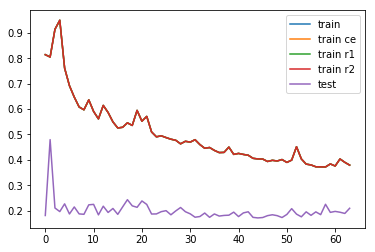

early stop


In [75]:
for epoch in range(epochs):
    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, 40)):
        batch_weights = np.array([class_weights[y] for y in batch_y])#.flatten()#.reshape(-1,1)

        batch_loss = sess.run([train_step, loss, loss, loss, loss],
                              feed_dict={inp : batch_X[:,feature_mask],
                                         target: batch_y,
                                         loss_weights:batch_weights})
        curr_loss += np.array(batch_loss[1:])
    
    curr_loss /= i
    train_losses.append(curr_loss[0])
    train_ce.append(curr_loss[1])
    train_r1.append(curr_loss[2])
    train_r2.append(curr_loss[3])
    
    curr_loss = np.zeros(4)
          
        
    val_weights = np.array([class_weights[y] for y in y_te])#.reshape(-1,1)
    val_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te, loss_weights : val_weights})
    val_losses.append(val_loss)
    
    display.clear_output(wait=True)
    plt.plot(train_losses[n:], label='train')
    plt.plot(train_ce[n:], label='train ce')
    plt.plot(train_r1[n:], label='train r1')
    plt.plot(train_r2[n:], label='train r2')
    
    plt.plot(val_losses[n:], label='test')
    plt.legend()
    plt.show()
    
    if epoch > 40:
        if np.argmin(np.array(val_losses[-20:])) == 0:
            print("early stop")
            break
            
    
    #zero_weights.append(np.abs(sess.run(weight_layer.w)).min())
        #print(batch_loss[1])

In [76]:
np.array(val_losses[-20:])  

array([0.17170314, 0.17321236, 0.18057978, 0.18412013, 0.18060762,
       0.17321223, 0.18536344, 0.2081416 , 0.18662906, 0.17604607,
       0.19564372, 0.18185163, 0.19551134, 0.18459737, 0.22531286,
       0.19351383, 0.1973642 , 0.1940897 , 0.18933259, 0.20970924],
      dtype=float32)

In [77]:
out_ = tf.nn.softmax(out)

In [78]:
pred = (sess.run(out, feed_dict={inp:X_te[:,feature_mask]}) > 0.5).astype(int)[:,1]

print(accuracy_score(y_te, pred))
print(f1_score(y_te, pred))

print(classification_report(y_te, pred))
#print(classification.zero_one_loss(y_te, pred))

mask = y_te < 0.5

print(accuracy_score(y_te[mask], pred[mask]), accuracy_score(y_te[np.logical_not(mask)], pred[np.logical_not(mask)]))

0.776173285198556
0.8597285067873303
             precision    recall  f1-score   support

        0.0       0.89      0.30      0.45        84
        1.0       0.76      0.98      0.86       193

avg / total       0.80      0.78      0.73       277

0.2976190476190476 0.9844559585492227


In [79]:
y_te

array([0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1.

In [80]:
pred.flatten().astype(float)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1.

In [81]:
importances = sess.run(dfs.weight_layer.w)

In [85]:
mask = importances.argsort()[::-1][:40]

array([ 364,  383,  424,  335,  407,  371,  323,  419,  290,  278,  289,
        273,  251,  257,  317,  314,  400,  305,  283,  272,  300,  691,
        665,  322,  318,  660,  969,  477,  231,  815,  624, 1043, 1089,
        448,  319,  834, 1214, 1447,   13,  100])

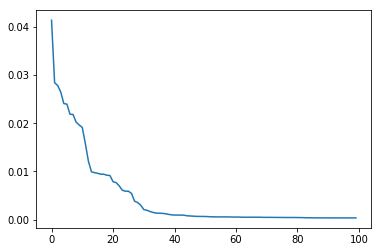

In [82]:
plt.plot(sorted(abs(importances))[::-1][:100])
plt.show()

In [486]:
sorted(abs(importances))[::-1][:60]

[0.043947864,
 0.043517802,
 0.035599638,
 0.03054874,
 0.029942408,
 0.024042096,
 0.022956392,
 0.022902142,
 0.022251979,
 0.021520147,
 0.020994166,
 0.016128628,
 0.015774554,
 0.013611497,
 0.013058648,
 0.011487326,
 0.010807884,
 0.01039926,
 0.0099691935,
 0.009339377,
 0.009335187,
 0.008031922,
 0.007830334,
 0.0077995034,
 0.007034731,
 0.0065056654,
 0.0057725166,
 0.0057263044,
 0.004963694,
 0.0046621305,
 0.0037396562,
 0.00345898,
 0.0028671261,
 0.0028366707,
 0.0022553024,
 0.0021701925,
 0.0016539771,
 0.0015091196,
 0.0010914928,
 0.00103581,
 0.0009411759,
 0.00087193074,
 0.0008696771,
 0.0008650388,
 0.0007399394,
 0.0006875464,
 0.000637955,
 0.0006377594,
 0.00063691364,
 0.00063677575,
 0.0006332269,
 0.00060557656,
 0.00058413035,
 0.00057808944,
 0.000575044,
 0.0005419304,
 0.00053618243,
 0.00049996027,
 0.0004913056,
 0.0004888583]

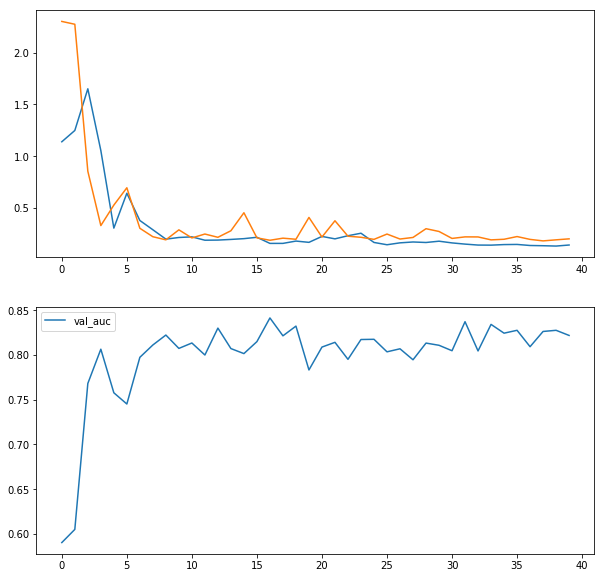

early stop


In [109]:
#def train_network(name, session, feature_mask):
name = 'test_9'
session = tf.Session()

n_features = feature_mask.sum()

with tf.variable_scope(name) as train_scope:
    ## Initialize network
    inp = tf.placeholder(tf.float32, [None, n_features])
    dfs = DFS("DFS", n_features)
    logits, out = dfs(inp)

    ##Prepare target and loss weights
    target = tf.placeholder(tf.float32, [None])
    loss_weights = tf.placeholder(tf.float32, [None])

    ##Loss terms
    ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(target, tf.int32), 2), logits, weights=loss_weights)
    features_weights_regularization = 0.1 * dfs.get_weighted_layer_regularization_term(0.5)
    network_weights_regularization = 0.0002 * dfs.get_dense_layers_regularization_term(0.5)

    loss = ce_loss + features_weights_regularization + network_weights_regularization

    optimizer = tf.train.AdamOptimizer()
    train_step = optimizer.minimize(loss, var_list=tf.trainable_variables(name))

    sess.run(tf.global_variables_initializer())



train_ce_loss = []
val_ce_loss = []
val_auc_scores = []

for epoch in range(epochs):
    curr_loss = 0

    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, 40)):
        batch_weights = np.array([class_weights[y] for y in batch_y])

        batch_loss = sess.run([train_step, ce_loss],
                              feed_dict={inp : batch_X[:,feature_mask],
                                         target: batch_y,
                                         loss_weights:batch_weights})

        curr_loss += batch_loss[1] * batch_X.shape[0]


    val_weights = np.array([class_weights[y] for y in y_te])
    val_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te, loss_weights : val_weights})
    val_auc = roc_auc_score(y_te, sess.run(out,  feed_dict={inp : X_te[:,feature_mask]})[:,1])

    val_ce_loss.append(val_loss)
    val_auc_scores.append(val_auc)
    train_ce_loss.append(curr_loss / X_tr.shape[0])

    
    f, (a1, a2) = plt.subplots(2,1,figsize = (10,10))
    display.clear_output(wait=True)
    a1.plot(train_ce_loss[2:], label='train ce')
    a1.plot(val_ce_loss[2:], label = 'val ce')
    
    a2.plot(val_auc_scores[2:], label='val_auc')

    plt.legend()
    plt.show()

    
    if epoch > 40:
        if np.argmin(np.array(val_losses[-20:])) == 0:
            print("early stop")
            break


    #zero_weights.append(np.abs(sess.run(weight_layer.w)).min())
        #print(batch_loss[1])